In [1]:
import json
#import io
import sqlalchemy as sal
import getpass
import pandas as pd
from urllib.request import urlopen

In [2]:
#counties=json.load(io.open("gz_2010_us_050_00_5m.json", encoding='latin-1'))

In [3]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [4]:
counties["features"][0].keys()

dict_keys(['type', 'properties', 'geometry', 'id'])

In [5]:
counties["features"][0]["id"]

'01001'

In [6]:
counties["features"][0]["properties"]

{'GEO_ID': '0500000US01001',
 'STATE': '01',
 'COUNTY': '001',
 'NAME': 'Autauga',
 'LSAD': 'County',
 'CENSUSAREA': 594.436}

In [7]:
counties.keys()

dict_keys(['type', 'features'])

In [8]:
#limit 10 CA counties to speed up mapping
cacounties={}
cacounties["type"] = counties["type"]
cafeat=[]

for feat in counties["features"]:
    if feat["id"].startswith("06"):
        cafeat.append(feat)

cacounties["features"] = cafeat

In [9]:
#parameters of the AWS database
endpoint = "capstone.clihskgj8i7s.us-west-2.rds.amazonaws.com"
user="group3"
db="db1"
#pw=getpass.getpass("Enter database password")
pw=open("/Users/daniel/Desktop/.awsdb","r").read().rstrip()

In [10]:
engine = sal.create_engine('postgresql://%s:%s@%s/%s' % (user, pw, endpoint, db))

In [11]:
pd.read_sql("select * from covidlocs limit 1", engine)

uid  iso2 iso3 code3    fips   admin2 province_state country_region  \
0  84001001  US    USA  840   1001.0  Autauga        Alabama             US   

    latitude  longitude          combined_key  population  
0  32.539527 -86.644082  Autauga, Alabama, US     55869.0

In [12]:
pd.read_sql("select * from covidcases limit 1", engine)

cid      cloc       rdate  ncas ctype
0    1  84001001  2020-01-22     0     C

In [13]:
#SQL query which returns total cases as f(time) for one county
query="""
select l.admin2, c.rdate, c.ncas as TotalCases
from covidlocs l, covidcases c
where l.uid = c.cloc and l.admin2 = 'Los Angeles' 
and c.ctype = 'C'
order by TotalCases desc
"""
df=pd.read_sql(query, engine)

<AxesSubplot:xlabel='rdate'>

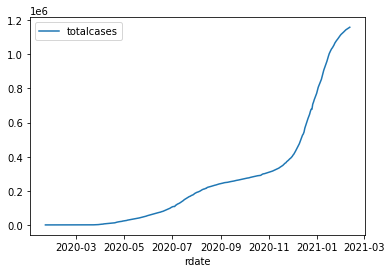

In [14]:
df.plot(x="rdate", y="totalcases")

In [15]:
#SQL query which returns total number of cases by county for California
query="""
select l.admin2, l.province_state, l.fips, 
round(c.ncas/l.population*100000) as casper100k
from covidlocs l, covidcases c
where l.uid = c.cloc and l.iso3 = 'USA' 
and c.ctype = 'C'
and c.rdate = '2021/02/10'
and l.province_state = 'California'
order by casper100k desc
"""
df=pd.read_sql(query, engine)

In [16]:
#get rid of NaN fips codes, convert to string after rounding
import numpy as np
df=df[df["fips"].apply(lambda x: not np.isnan(x))]

In [17]:
df["fips"]=df["fips"].astype(int).astype(str).str.zfill(5)

In [18]:
df.tail()

admin2 province_state   fips  casper100k
55  Del Norte     California  06015      3276.0
56     Sierra     California  06091      3195.0
57    Trinity     California  06105      2605.0
58   Mariposa     California  06043      2215.0
59   Humboldt     California  06023      2195.0

In [71]:
def caseclass(cp100k):
    if cp100k < 2000:
        cp100k = "< 2,000"
    elif cp100k < 5000:
        cp100k = "2,000 - 5,000"
    elif cp100k < 10000:
        cp100k = "5,000 - 10,000"
    elif cp100k < 15000:
        cp100k = "10,000 - 15,000"
    else:
        cp100k = "> 15,000"
    
    return cp100k

df["caseclass"] = df["casper100k"].apply(caseclass)
df.head()

admin2 province_state   fips  casper100k        caseclass
0       None     California  90006         NaN         > 15,000
1  Out of CA     California  80006         NaN         > 15,000
2     Lassen     California  06035     17964.0         > 15,000
3   Imperial     California  06025     14651.0  10,000 - 15,000
4      Kings     California  06031     13966.0  10,000 - 15,000

In [19]:
hospitals = pd.read_sql("select * from hospitals", engine, index_col="oshpd_id")
hospitals.head()

zipcode                                               name  \
oshpd_id                                                                
106010735    94501                                   ALAMEDA HOSPITAL   
106010739    94705  ALTA BATES SUMMIT MEDICAL CENTER-ALTA BATES CA...   
106010776    94609           UCSF BENIOFF CHILDREN'S HOSPITAL OAKLAND   
106010846    94602                                  HIGHLAND HOSPITAL   
106010937    94609                   ALTA BATES SUMMIT MEDICAL CENTER   

          county_name  latitude   longitude  
oshpd_id                                     
106010735     Alameda  37.76266 -122.253991  
106010739     Alameda  37.85645 -122.257430  
106010776     Alameda  37.83722 -122.267470  
106010846     Alameda  37.79925 -122.231380  
106010937     Alameda  37.82106 -122.262570

In [54]:
hospitals["size"] = 10
hospitals["color"] = "Hospitals"

In [21]:
pms=pd.read_sql("select distinct sid,fwy,direc,latitude,longitude,stype,name,lanes from pemslocs", engine, index_col="sid")
#pms=pd.read_sql("select * from pemslocs", engine, index_col="sid")
pms.head(n=2)

fwy direc   latitude   longitude stype          name  lanes
sid                                                                
771826  405     N  33.787054 -118.094505    ML     N. OF 605      4
413379   80     E  38.334599 -122.017779    OR  Rivera Rd on      1

In [22]:
pms["lanes"].unique()

array([4, 1, 2, 3, 5, 6, 7, 8])

In [55]:
pms["color"] = "Traffic Sensors"
pms["size"] = 1

In [24]:
import plotly.express as px
import plotly.graph_objects as go

In [75]:
maxcases=df["casper100k"].max()

fig = px.choropleth_mapbox(df, geojson=cacounties, locations='fips', 
                           #color='casper100k',
                           #color_continuous_scale="Blues",
                           color='caseclass',
                           range_color=(0, maxcases),
                           mapbox_style="carto-positron",
                           zoom=5, center = {"lat": 37, "lon": -120},
                           opacity=0.5,
                           hover_data=["casper100k","admin2"],
                           labels={'casper100k':'Number of Covid-19 cases per 100k residents',
                                   'caseclass': 'Number of Covid-19 cases per 100k residents',
                                  'admin2': "County"},
                           color_discrete_map={'> 15,000': 'midnightblue',
                                              '10,000 - 15,000' : 'blue',
                                              '5,000 - 10,000': 'lightblue',
                                              '2,000 - 5,000': 'lightgray'},
                           height=800,
                           width=800)

fig_sc = px.scatter_mapbox(hospitals, lat="latitude", lon="longitude",
                           hover_data=["name"], labels={"name":"Facility name"},
                           size="size",  size_max=10,
                           opacity=0.5,
                           color="color",
                           color_discrete_map={"Hospitals":"green"})

fig_tr = px.scatter_mapbox(pms, lat="latitude", lon="longitude",
                           hover_data=["fwy","direc","name","stype","lanes"],
                           labels={"fwy":"Freeway", 
                                   "direc": "Direction",
                                    "name": "Sensor Name",
                                   "stype": "Type",
                                   "lanes": "Lanes"},
                           opacity=0.9,
                           color="color",
                           color_discrete_map={"Traffic Sensors":"red"},
                           size="size",
                           size_max=2)

#fig.show()
#fig_sc = px.scatter_geo(hospitals, locations="iso_alpha",
#                    hover_name="Country", text = "Country",size="Value_Air",
#                     animation_frame="Year", animation_group="Country",
fig.add_trace(fig_sc.data[0])
fig.add_trace(fig_tr.data[0])

#fig.update_layout(showlegend=False)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.95
))

#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
#fig_sc.show()

In [76]:
fig.write_image("metadata.jpg")
fig.write_image("metadata.pdf")
fig.write_image("metadata.svg")

In [27]:
!ls 

'4.14.1'

In [28]:
mapbox_access_token = open("/Users/daniel/Desktop/.mapbox_token").read()
#mapbox_access_token

In [29]:
#same plot using go

fig_sc = go.Figure(go.Scattermapbox(
        lat=hospitals["latitude"], lon=hospitals["longitude"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=15, 
            symbol='hospital',
            color="blue")))

fig_tr = go.Figure(go.Scattermapbox(
        lat=pms["latitude"], lon=pms["longitude"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=15, 
            symbol='car',
            color="red")))

fig_sc.update_layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=37,
            lon=-120
        ),
        pitch=0,
        zoom=5
    ),
)

fig_sc.add_trace(fig_tr.data[0])

fig_sc.show()

In [64]:
help(px.choropleth_mapbox)

Help on function choropleth_mapbox in module plotly.express._chart_types:

choropleth_mapbox(data_frame=None, geojson=None, featureidkey=None, locations=None, color=None, hover_name=None, hover_data=None, custom_data=None, animation_frame=None, animation_group=None, category_orders=None, labels=None, color_discrete_sequence=None, color_discrete_map=None, color_continuous_scale=None, range_color=None, color_continuous_midpoint=None, opacity=None, zoom=8, center=None, mapbox_style=None, title=None, template=None, width=None, height=None)
        In a Mapbox choropleth map, each row of `data_frame` is represented by a
        colored region on a Mapbox map.
        
    Parameters
    ----------
    data_frame: DataFrame or array-like or dict
        This argument needs to be passed for column names (and not keyword
        names) to be used. Array-like and dict are tranformed internally to a
        pandas DataFrame. Optional: if missing, a DataFrame gets constructed
        under the ho